# Multi Layer Perceptron Basic Practice with MNIST Data

#### Setting

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [6]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.0.1+cpu  Device: cpu


In [7]:
BATCH_SIZE = 32
EPOCHS = 10

In [8]:
# MNIST Data Download
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 9912422/9912422 [00:03<00:00, 2978861.96it/s]


Extracting ../data/MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ../data/MNIST\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 14450160.30it/s]


Extracting ../data/MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ../data/MNIST\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3792193.42it/s]


Extracting ../data/MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/MNIST\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/MNIST\MNIST\raw



In [9]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


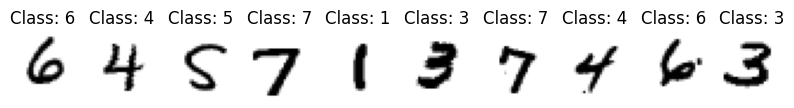

In [10]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

#### Modeling

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512) 
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, 10) 

    def forward(self, x):
        x = x.view(-1, 28 * 28) 
        x = self.fc1(x) 
        x = F.sigmoid(x) 
        x = self.fc2(x) 
        x = F.sigmoid(x) 
        x = self.fc3(x) 
        
        x = F.log_softmax(x, dim = 1) # log
        return x

In [12]:
model = Net().to(DEVICE) 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5) 
criterion = nn.NLLLoss() 

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


#### Train & Test

In [13]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step() 

        if batch_idx % log_interval == 0: 
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [14]:
def evaluate(model, test_loader):
    model.eval() 
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1] 
            correct += prediction.eq(label.view_as(prediction)).sum().item() 
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [15]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200) # 200 step마다 결과 출력
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.365524
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.258715
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 2.306816
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 2.297862
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 2.334387
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 2.242902
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 2.232351
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 2.264905
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 2.295022
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 2.218060

[EPOCH: 1], 	Test Loss: 2.2276, 	Test Accuracy: 19.21 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 2.199884
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 2.203935
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 2.178465
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 2.058565
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 2.007855
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 1.758489
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 1.396634
T